In [ ]:
from rubiks.cube import RubiksCube

# Initialize a Rubik's Cube with a specific size
cube = RubiksCube(size=3)

# Perform a clockwise rotation on the front face
cube.rotate_face(face='U', clockwise=True)

cube.state

In [ ]:
import gymnasium as gym
from dqn.model import QNetwork
from rubiks.env import RubiksCubeEnv
import torch
import torch.nn as nn
import torch.optim as optim

env = RubiksCubeEnv(size=3, scramble_moves=1)
input_dim = env.observation_space.shape[0]  # 6 * size^2
output_dim = env.action_space.n  # 12 (6 faces * 2 rotations)

model = QNetwork(input_dim, output_dim)  # Initialize with random weights and biases
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

num_episodes = 2000
max_steps = 10
gamma = 0.99

epsilon = 1.0 # Initial exploration rate, 1.0 means 100% exploration, 0.0 means 100% exploitation
min_epsilon = 0.01
epsilon_decay = 0.0002

reward_list = []

for episode in range(num_episodes):
    # Reset the game state for each episode
    state, _ = env.reset()
    total_reward = 0
    
    for step in range(max_steps):
        # SAMPLING
        # Choose action (e-greedy)
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        random = torch.rand(1).item() # random float between 0 and 1
        if random < epsilon:
            action = env.action_space.sample()  # explore
        else:
            q_values = model(state_tensor)
            action = q_values.argmax().item()  # exploit
            
        # Perform action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        # Convert next state to tensor
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

        # TRAINING
        # Calculate target Q-value (the temporal difference target)
        with torch.no_grad():
            max_next_q = model(next_state_tensor).max().item()
            target_q = reward if done else reward + gamma * max_next_q
        
        # Get predicted Q-value for the current state-action pair
        predicted_q = model(state_tensor)[0, action] # [0, action] to get the scalar value
        
        # Calculate loss
        loss = loss_fn(predicted_q, torch.tensor(target_q, dtype=torch.float32))
        
        optimizer.zero_grad() # Clear gradients
        loss.backward() # Backpropagation, this computes gradients
        optimizer.step() # Update weights based on gradients
        
        # Move to next state
        state = next_state
        
        if done:
            break
        
    # Decay epsilon (less exploration over time)
    epsilon = max(min_epsilon, epsilon - epsilon_decay)
    
    reward_list.append(reward)
    
    print(f"Episode {episode+1}, Total Reward: {total_reward:.1f}, Epsilon: {epsilon:.3f}")

Episode 1, Total Reward: 0.0, Epsilon: 1.000
Episode 2, Total Reward: 0.0, Epsilon: 1.000
Episode 3, Total Reward: 0.0, Epsilon: 0.999
Episode 4, Total Reward: 0.0, Epsilon: 0.999
Episode 5, Total Reward: 0.0, Epsilon: 0.999
Episode 6, Total Reward: 0.0, Epsilon: 0.999
Episode 7, Total Reward: 0.0, Epsilon: 0.999
Episode 8, Total Reward: 0.0, Epsilon: 0.998
Episode 9, Total Reward: 0.0, Epsilon: 0.998
Episode 10, Total Reward: 0.0, Epsilon: 0.998
Episode 11, Total Reward: 0.0, Epsilon: 0.998
Episode 12, Total Reward: 0.0, Epsilon: 0.998
Episode 13, Total Reward: 0.0, Epsilon: 0.997
Episode 14, Total Reward: 0.0, Epsilon: 0.997
Episode 15, Total Reward: 0.0, Epsilon: 0.997
Episode 16, Total Reward: 0.0, Epsilon: 0.997
Episode 17, Total Reward: 0.0, Epsilon: 0.997
Episode 18, Total Reward: 0.0, Epsilon: 0.996
Episode 19, Total Reward: 0.0, Epsilon: 0.996
Episode 20, Total Reward: 0.0, Epsilon: 0.996
Episode 21, Total Reward: 1.0, Epsilon: 0.996
Episode 22, Total Reward: 0.0, Epsilon: 0.9

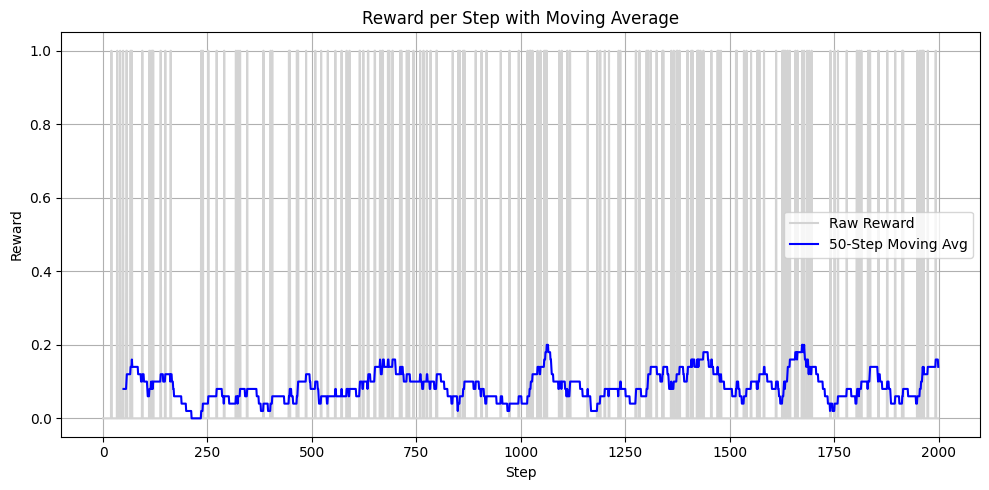

In [ ]:
# Plot rewards moving avg over time
import matplotlib.pyplot as plt
import numpy as np

window_size = 50  # adjust this as needed
reward_array = np.array(reward_list)
moving_avg = np.convolve(reward_array, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(reward_list, color='lightgray', label='Raw Reward')
plt.plot(range(window_size - 1, len(reward_list)), moving_avg, color='blue', label=f'{window_size}-Step Moving Avg')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Reward per Step with Moving Average')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# DQN w Replay Buffer

In [ ]:
import gymnasium as gym
from dqn.model import QNetwork
from rubiks.env import RubiksCubeEnv
import torch
import torch.nn as nn
import torch.optim as optim

env = RubiksCubeEnv(size=3, scramble_moves=1)
input_dim = env.observation_space.shape[0]  # 6 * size^2
output_dim = env.action_space.n  # 12 (6 faces * 2 rotations)

model = QNetwork(input_dim, output_dim)  # Initialize with random weights and biases
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

num_episodes = 2000
max_steps = 10
gamma = 0.99

epsilon = 1.0 # Initial exploration rate, 1.0 means 100% exploration, 0.0 means 100% exploitation
min_epsilon = 0.01
epsilon_decay = 0.0002

replay_buffer = []  # This will store tuples of (state, action, reward, next_state, done)
buffer_size = 10000  # Maximum size of the replay buffer
batch_size = 32  # Size of the minibatch for training

reward_list = []

for episode in range(num_episodes):
    # Reset the game state for each episode
    state, _ = env.reset()
    total_reward = 0
    
    for step in range(max_steps):
        # SAMPLING
        # Choose action (e-greedy)
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        random = torch.rand(1).item() # random float between 0 and 1
        if random < epsilon:
            action = env.action_space.sample()  # explore
        else:
            q_values = model(state_tensor)
            action = q_values.argmax().item()  # exploit
            
        # Perform action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        # Convert next state to tensor
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        
        # Store transition in replay buffer
        # If the buffer is full, remove the oldest transition
        if len(replay_buffer) >= buffer_size:
            replay_buffer.pop(0)
        
        replay_buffer.append((state_tensor, action, reward, next_state_tensor, done))

        # TRAINING
        # Sample a random minibatch from the replay buffer
        if len(replay_buffer) < batch_size:  # Ensure we have enough samples to sample a minibatch
            continue
        minibatch = random.sample(replay_buffer, batch_size)
        
        # Stack the minibatch elements
        state_batch = torch.cat([transition[0] for transition in minibatch]) # (batch_size, state_dim)
        action_batch = torch.tensor([transition[1] for transition in minibatch]) # (batch_size,)
        reward_batch = torch.tensor([transition[2] for transition in minibatch], dtype=torch.float32) # (batch_size,)
        next_state_batch = torch.cat([transition[3] for transition in minibatch]) # (batch_size, state_dim)
        done_batch = torch.tensor([transition[4] for transition in minibatch], dtype=torch.float32) # (batch_size,)
        
        # Calculate target Q-value (the temporal difference target)
        with torch.no_grad():
            max_next_q_batch = model(next_state_batch).max(dim=1)[0] # max_a' Q(s', a') for each next state in the minibatch
            target_q_batch = reward_batch + (gamma * max_next_q_batch * (~done_batch)) # If done, no future reward
        
        # Get batch predicted Q-values
        q_values = model(state_batch)  # Shape: [batch_size, num_actions]
        predicted_q_batch = q_values[range(batch_size), action_batch]
        
        # Calculate loss
        loss = loss_fn(predicted_q, target_q_batch)
        
        optimizer.zero_grad() # Clear gradients
        loss.backward() # Backpropagation, this computes gradients
        optimizer.step() # Update weights based on gradients
        
        # 4. Move to next state
        state = next_state
        
        if done:
            break
        
    # 5 Decay epsilon (less exploration over time)
    epsilon = max(min_epsilon, epsilon - epsilon_decay)
    
    reward_list.append(reward)
    
    print(f"Episode {episode+1}, Total Reward: {total_reward:.1f}, Epsilon: {epsilon:.3f}")

In [ ]:
# Plot rewards moving avg over time
import matplotlib.pyplot as plt
import numpy as np

window_size = 50  # adjust this as needed
reward_array = np.array(reward_list)
moving_avg = np.convolve(reward_array, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(reward_list, color='lightgray', label='Raw Reward')
plt.plot(range(window_size - 1, len(reward_list)), moving_avg, color='blue', label=f'{window_size}-Step Moving Avg')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Reward per Step with Moving Average')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()